# GPT From scratch for product review generation and market research



**This notebook serves as a comprehensive guide to implement, code, and train a basic Generative Pretrained Transformer (GPT) model from scratch using Keras. It is based on the methodologies and code provided in “Generative Deep Learning, 2nd Edition” by David Foster (2023) (https://learning.oreilly.com/library/view/generative-deep-learning/9781098134174/ ) as well as the official Keras guides. The objective is to provide a hands-on approach to understanding and applying the principles of generative models, specifically focusing on the GPT model. This study aims to contribute to the broader understanding of generative deep learning and its applications.**

# Introduction
**In the realm of machine learning, the ability to predict future data points based on historical ones is a critical capability. Autoregressive models, a subset of statistical algorithms, are designed to accomplish this task. They form the backbone of Large Language Models (LLMs), particularly those powered by the Generative Pre-trained Transformer (GPT).**

**GPT is a profound neural network that evolves from the foundational transformer architecture. It leverages the principle of autoregression, a statistical method widely used in time series analysis, to predict the next element in a sequence by analyzing previous elements. This model verifies probability-based relationships between sequential data points and uses this probabilistic link to infer the next element in a sequence that has not been previously observed.**

**This notebook delves into the intricacies of understanding and implementing the GPT model from scratch. It explores the fundamental concepts of autoregressive models, the attention mechanism, and the transformer architecture. It also provides a step-by-step guide on how to implement GPT, including sections on queries, keys, values, multihead attention, and causal masking.**

# Context:
**The goal here is to train a GPT model to generate beauty product reviews, a simple use case for such model would be to assess and evaluate the performance and popularity of a certain product or to enhance pre existing recommendation systems.**

# **What are autoregressive models?**
**Autoregressive models represent a subset of statistical algorithms in the machine learning landscape, designed to predict the next element in a sequence by analyzing previous elements. These models are based on the principle of autoregression - a statistical method widely used in time series analysis - where the current value is assumed to be a synthesis of its historical values. Using mathematical strategies similar to those of time series prediction, autoregressive models verify probability-based relationships between sequential data points. Using this probabilistic link, the model is equipped to infer the next element in a sequence that has not been previously observed. For example, an autoregressive model, trained on a corpus of English sentences, can discern a pattern in which "is" invariably follows "there". Based on this pattern, it can then construct new sequences that consistently associate "there is".[1]**

**Autoregressive modeling serves as a pivotal element in the architecture of Large Language Models (LLMs), Particulary those powered by the Generative Pre-trained Transformer (GPT), which is a profound neural network that evolves from the foundational transformer architecture.[1]**

**More formally , the joint probability of a sequence of words $( w_1, w_2, …, w_n )$ is decomposed as:**

$$P(w_1​,w_2​,…,w_n​)=P(w_1​)⋅P(w_2​∣w_1​)⋅…⋅P(w_n​∣w_1​,…,w_{n−1}​)$$

**For a sequence of words, the prediction of the next word $( w_{t+1} )$ given the previous $( t )$ words is:**

$$P(w_{t+1}​∣w_1​,…,w_t​)=softmax(f(w_1​,…,w_t​))$$

**where $( f )$ is a function represented by the neural network (such as GPT), and the softmax function is used to convert the outputs into a probability distribution.**

**The basic transformer model is composed of two primary components: an encoder and a decoder. The encoder is responsible for comprehending natural language input, while the decoder is tasked with generating natural language output.**

**However, in the context of GPT, the model uses solely the decoder component to perform autoregressive language modeling:**

$$Decoder(w_1​,…,w_t​)=softmax(Linear(h_t​))$$

**where $( h_t )$ is the hidden state at position $( t )$, and the Linear layer maps this hidden state to a vector of the size of the vocabulary, followed by a softmax to create a probability distribution over all possible next words
Consequently, when tasked with predicting the subsequent word in a sequence, a GPT-LLM evaluates the probability distribution collected from the extensive text corpus on which it has been trained.**

**The predicted word $(\hat{w}_{t+1})$ is the one with the highest probability:**

$$\hat{w}_{t+1}​= argmax(P(w_{t+1​}∣w_1​,…,w_t​))$$

In [ ]:
import pandas as pd
from tensorflow.keras import layers
%load_ext autoreload
%autoreload 2
import numpy as np
import json
import re
import string
from IPython.display import display, HTML
import tensorflow as tf
from tensorflow.keras import models, losses, callbacks
import warnings
warnings.filterwarnings("ignore")

# Constants and model parameters


In [2]:

VOCAB_SIZE = 5000 # the size of the vocabulary
MAX_LEN = 1000 # the maximum length of the sequences,
EMBEDDING_DIM = 768 # the dimension of the word embeddings
KEY_DIM = 64 # the dimension of the keys in the attention mechanism
N_HEADS = 12 #  the number of attention heads
FEED_FORWARD_DIM = 3072 #  the dimension of the feed-forward network
VALIDATION_SPLIT = 0.2 # the fraction of data to be used for validation
SEED = 42 # the random seed for reproducibility
LOAD_MODEL = False #  flag to load a pre-trained model
BATCH_SIZE = 32 # the size of the batches for training
EPOCHS = 5 # the number of epochs for training

# About the data:

This dataset was collected via Python scraper in March 2023 and contains:
information about all beauty products (over 8,000) from the Sephora online store, including product and brand names, prices, ingredients, ratings, and all features.
user reviews (about 1 million on over 2,000 products) of all products from the Skincare category, including user appearances, and review ratings by other users

source : https://www.kaggle.com/datasets/nadyinky/sephora-products-and-skincare-reviews

In [3]:
products = pd.read_csv('product_info.csv')
products.head()

,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,...,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0


In [6]:
reviews = pd.read_csv('reviews_1250-end.csv')
reviews.head()

,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1945004256,5,1.0,0.000000,2,2,0,2022-12-10,I absolutely L-O-V-E this oil. I have acne pro...,A must have!,lightMedium,green,combination,NaN,P379064,Lotus Balancing & Hydrating Natural Face Treat...,Clarins,65.0
1,1,5478482359,3,1.0,0.333333,3,2,1,2021-12-17,I gave this 3 stars because it give me tiny li...,it keeps oily skin under control,mediumTan,brown,oily,black,P379064,Lotus Balancing & Hydrating Natural Face Treat...,Clarins,65.0
2,2,29002209922,5,1.0,1.000000,2,0,2,2021-06-07,Works well as soon as I wash my face and pat d...,Worth the money!,lightMedium,brown,dry,black,P379064,Lotus Balancing & Hydrating Natural Face Treat...,Clarins,65.0
3,3,7391078463,5,1.0,1.000000,2,0,2,2021-05-21,"this oil helped with hydration and breakouts, ...",best face oil,lightMedium,brown,combination,blonde,P379064,Lotus Balancing & Hydrating Natural Face Treat...,Clarins,65.0
4,4,1766313888,5,1.0,1.000000,13,0,13,2021-03-29,This is my first product review ever so that s...,Maskne miracle,mediumTan,brown,combination,black,P379064,Lotus Balancing & Hydrating Natural Face Treat...,Clarins,65.0


The product information and reviews are merged based on the product ID. Only the product name and review text are kept, and rows with missing values are dropped

In [7]:
text = pd.merge(left = products, right=reviews, on = 'product_id')[['product_name_x','review_text']].dropna()
text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49918 entries, 0 to 49976
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   product_name_x  49918 non-null  object
 1   review_text     49918 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [8]:
text.head()

,product_name_x,review_text
0,GENIUS Collagen Calming Relief,This product is amazing. Makes my skin feel so...
1,GENIUS Collagen Calming Relief,I pair this with the algae niacinamide moistur...
2,GENIUS Collagen Calming Relief,Definitely my favorite I use it for under eye ...
3,GENIUS Collagen Calming Relief,I bought this with the toner as I was looking ...
4,GENIUS Collagen Calming Relief,Been using for months now. I went in and asked...


The data is converted to JSON format, parsed, and then filtered to keep only the product review and the review text.

In [9]:
json_data = text.to_json(orient='records')
parsed_data = pd.read_json(json_data)
data = [
    'product review:' + row['product_name_x'] + ' | ' + row['review_text']
    for index, row in parsed_data.iterrows()
]


In [10]:
# Example of input data
data[0]

'product review:GENIUS Collagen Calming Relief | This product is amazing. Makes my skin feel so soft and hydrated and helps with any irritation I have.'

**Next the data is tokenized and vectorized using the TextVectorization layer from TensorFlow. The text is standardized to lowercase, the maximum number of tokens is set to 5000, the output mode is set to “int” to output integer indices, and the output sequence length is set to 201 (200 tokens for the input and 1 token for the output).**

In [11]:
def format_string(s):
    s = re.sub(f"([{string.punctuation}])", r' \1 ', s)
    s = re.sub(' +', ' ', s)
    return s

text_data = [format_string(x) for x in data]
#Create a tf.data Dataset
text_dataset = tf.data.Dataset.from_tensor_slices(text_data).batch(32).shuffle(1000)

vectorize_layer = layers.TextVectorization(
    standardize = 'lower',
    max_tokens = 5000,
    output_mode = "int",
    output_sequence_length = 200 + 1,
)

vectorize_layer.adapt(text_dataset)
vocab = vectorize_layer.get_vocabulary()

**The inputs are prepared by tokenizing the sentences and creating the input and output sequences. The input sequence consists of all tokens except the last one, and the output sequence consists of all tokens except the first one.**

In [12]:
def transform_inputs(text):
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y

train_dataset = text_dataset.map(transform_inputs)

**To enhance efficiency during the training process, it would be ideal if the attention layer could process every word in the input simultaneously, making predictions about the next word for each. In simpler terms, we want our GPT model to be capable of managing multiple query vectors concurrently (i.e., in the form of a matrix). One might assume that we could simply group the vectors into a matrix and let linear algebra do the heavy lifting. While this is partially correct, there's an additional step required - we need to apply a mask to the dot product of the query/key to prevent future words from inadvertently revealing information. This process is referred to as causal masking**

In [13]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

# **the Attention mechanism**
**To comprehend how GPT operates, it's crucial to understand the attention mechanism. This mechanism distinguishes the Transformer architecture from recurrent language modeling methods.**

**Consider writing a sentence where the selection of the subsequent word is influenced by the preceding words ( autoregressive  aspect). For instance, if you begin a sentence like this:**

*The orange kitten tried to climb the tree but it was too…*

**It's evident that the next word should be something like "high". How do we deduce this? Specific words in the sentence assist us in making our decision. The fact that it's a kitten , not a bird, implies we prefer high over easy. If it were a fence instead of a tree, we might opt for tall as an alternative to high. Finally, the act of climbing the tree suggests that height is the issue .
Some words in the sentence are not significant at all. For instance, the fact that the kitten is orange doesn't affect our choice of the final word. Similarly, the minor words in the sentence (the, but, it, etc.) provide grammatical structure, but aren't crucial in determining the required adjective.
In essence, we're focusing on certain words in the sentence and largely disregarding others. It would be beneficial if our model could replicate this behavior.**

**An attention mechanism (also known as an attention head) in a Transformer is engineered to do precisely this. It can determine from where in the input it wants to extract information, enabling it to efficiently glean useful information without being obscured by irrelevant details. This adaptability makes it suitable for a variety of situations, as it can decide where to source information during inference[3]. On the other hand, a recurrent layer attempts to construct a generic hidden state that encapsulates a comprehensive representation of the input at each timestep. This approach's drawback is that many words already incorporated into the hidden vector may not be directly pertinent to the immediate task (e.g., predicting the next word), as we've observed. Attention heads circumvent this issue, as they can selectively amalgamate information from nearby words, contingent on the context.[3]**
## Queries, Keys, and Values
**So, how does an attention head determine where to source its information? Before we delve into the specifics, let's first understand its general operation, using another sentence example.[3]**

*The pink elephant tried to get into the car but it was too…*

**Suppose we're trying to predict the word that comes after 'too'. To assist in this task, other preceding words provide their insights, but the weight of their contributions is determined by their self-assuredness in their ability to predict words that follow 'too'.**

**For instance, the word 'elephant' might assertively suggest that the next word is likely related to size or loudness, while the word 'was' might not provide much insight to narrow down the possibilities.
In essence, an attention head can be viewed as a type of information retrieval system. A query (e.g., "What word follows too?") is made into a key/value store (other words in the sentence), and the output is a sum of the values, weighted by the compatibility between the query and each key.[3]**

**Now, let's examine the process in detail (Figure 1), referring back to our pink elephant sentence.[3]**
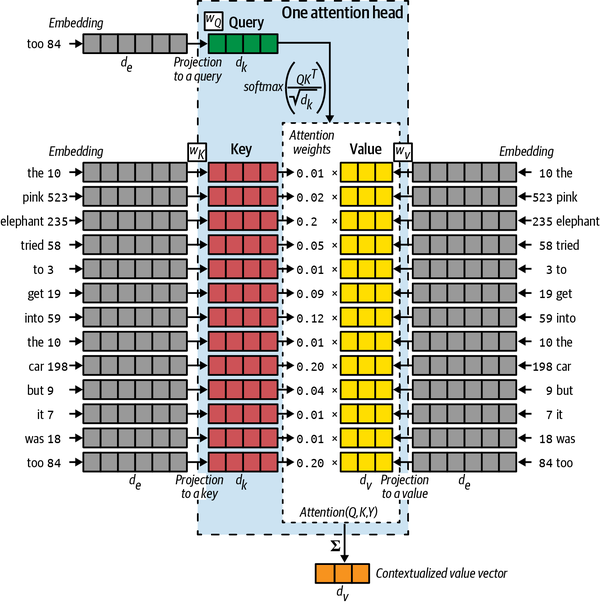

**The query $(Q)$ is essentially a representation of the current task (for instance, "What word follows too?"). In this case, it is obtained from the embedding of the word 'too', by transforming it through a weights matrix $W_Q$ to alter the vector's dimensionality from $d_e$ to $d_k$.[3]**

**The key vectors $(K)$ represent each word in the sentence. These can be viewed as descriptors of the types of prediction tasks each word can assist with. They are generated similarly to the query, by transforming each embedding through a weights matrix $W_k$ to alter each vector's dimensionality from $d_e$ to $d_k$. It's important to note that the keys and the query have the same length $(d_k)$.[3]**

**Within the attention head, each key is compared to the query using a dot product between each pair of vectors ($QK^T$)  where  $^T$ denotes the transposed matrix. This is why the keys and the query must be the same length. The higher this value is for a specific key/query pair, the more the key aligns with the query, allowing it to contribute more to the attention head's output. The resulting vector is scaled by the square root of $d_k$ to maintain the stability of the vector sum's variance (approximately equal to 1), and a softmax is applied to ensure the contributions add up to 1. This results in a vector of attention weights.[3]**

**The value vectors $(V)$ are also representations of the words in the sentence. These can be considered as the unweighted contributions of each word. They are obtained by transforming each embedding through a weights matrix $W_w$ to alter each vector's dimensionality from $d_e$ to $d_v$. Note that the value vectors do not necessarily need to be the same length as the keys and query (although they often are, for simplicity).[3]**

**The value vectors are multiplied by the attention weights to yield the attention for a given $Q, K,$ and $V$, as demonstrated in the following equation[3]:**
$$ Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

**To obtain the final output vector from the attention head, the attention is summed to give a vector of length d_k. This context vector captures a blended opinion from words in the sentence on the task of predicting what word follows "too"**

## **Multihead Attention**

**MultiHeadAttention layer combines the output from several attention heads. This allows each head to learn a unique attention mechanism, enabling the layer to understand more intricate relationships.**

**The combined outputs are then processed through a final weights matrix $W_o$ to project the vector to the required output dimension. In our scenario, this is identical to the input dimension of the query $(d_e)$, allowing for the layers to be sequentially stacked one on top of the other.**

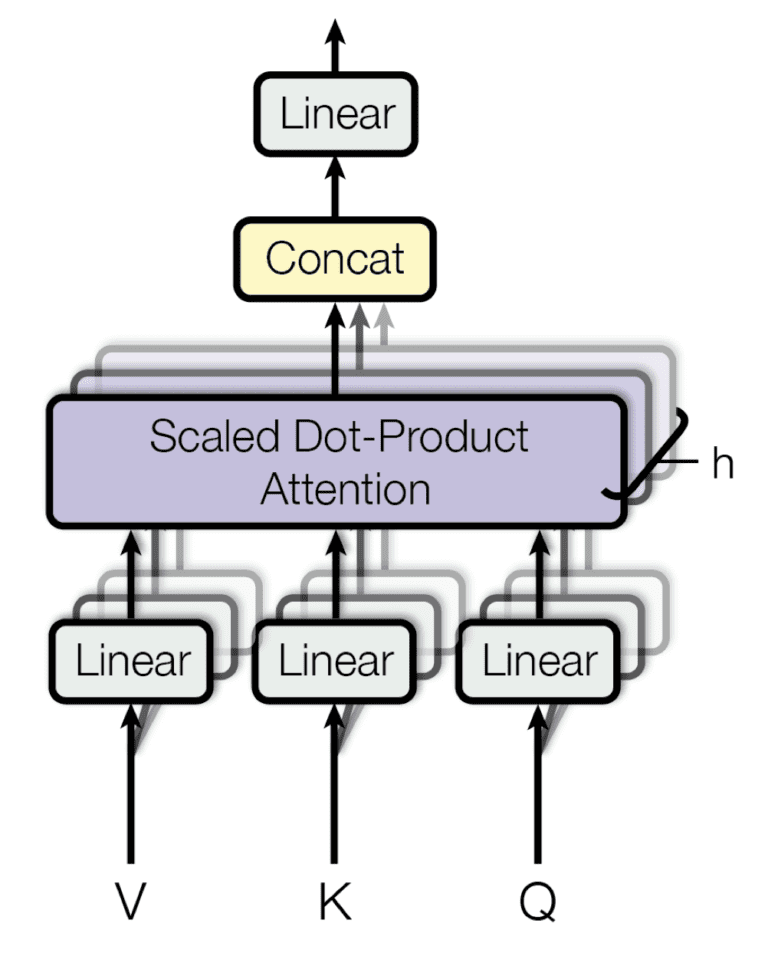

**Below is an implementation of the MultiHeadAttention inpired by [4], later on we will use the predefined keras MHA layer**

In [ ]:
from tensorflow import math, matmul, reshape, shape, transpose, cast, float32
from tensorflow.keras.layers import Dense, Layer
from keras.backend import softmax

# Scaled-Dot Product Attention Mechanism
class ScaledDotProductAttention(Layer):
    def __init__(self, **kwargs):
        super(ScaledDotProductAttention, self).__init__(**kwargs)

    def call(self, q, k, v, depth, mask=None):
        # Calculate attention scores with scaling
        scores = matmul(q, k, transpose_b=True) / math.sqrt(cast(depth, float32))

        # Apply the mask, if provided
        if mask is not None:
            scores += (mask * -1e9)

        # Softmax to obtain attention weights
        attention_weights = softmax(scores)

        # Output is the weighted sum of values
        return matmul(attention_weights, v)

# Multi-Head Attention Layer
class MultiHeadAttention(Layer):
    def __init__(self, num_heads, depth, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.depth = depth
        self.num_heads = num_heads
        self.Wq = Dense(depth)  # Query projection
        self.Wk = Dense(depth)  # Key projection
        self.Wv = Dense(depth)  # Value projection
        self.dense = Dense(kwargs.get('d_model'))  # Output projection

    def split_heads(self, x, batch_size):
        # Split the last dimension into (num_heads, depth)
        x = reshape(x, (batch_size, -1, self.num_heads, self.depth // self.num_heads))
        # Transpose for shape (batch_size, num_heads, seq_len, depth)
        return transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask=None):
        batch_size = shape(q)[0]

        # Linear projections
        q = self.split_heads(self.Wq(q), batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(self.Wk(k), batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(self.Wv(v), batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # Scaled dot-product attention
        scaled_attention = ScaledDotProductAttention()(q, k, v, self.depth, mask)

        # Concatenation of heads
        scaled_attention = transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = reshape(scaled_attention, (batch_size, -1, self.num_heads * (self.depth // self.num_heads)))

        # Final linear layer
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output


## **The Transformer Block**

**A Transformer block is an integral part of a Transformer model that incorporates skip connections, feed-forward layers, and normalization around the multihead attention layer. The query is circulated around the multihead attention layer and added to the output, forming a skip connection. This is a common feature in contemporary deep learning architectures, allowing the construction of deep neural networks that are less affected by the vanishing gradient problem. The skip connection acts as a gradient-free pathway, facilitating uninterrupted information transfer. Layer normalization is employed in the Transformer block to stabilize the training process. Unlike batch normalization, which normalizes the output from each channel to have a mean of 0 and standard deviation of 1 across the batch and spatial dimensions, layer normalization in a Transformer block normalizes each position of each sequence in the batch by calculating the normalizing statistics across the channels. This is the exact inverse of batch normalization in terms of how the normalization statistics are computed. Finally, the Transformer block includes a set of feed-forward (densely connected) layers. These layers enable the component to extract more complex features as the network delves deeper.**

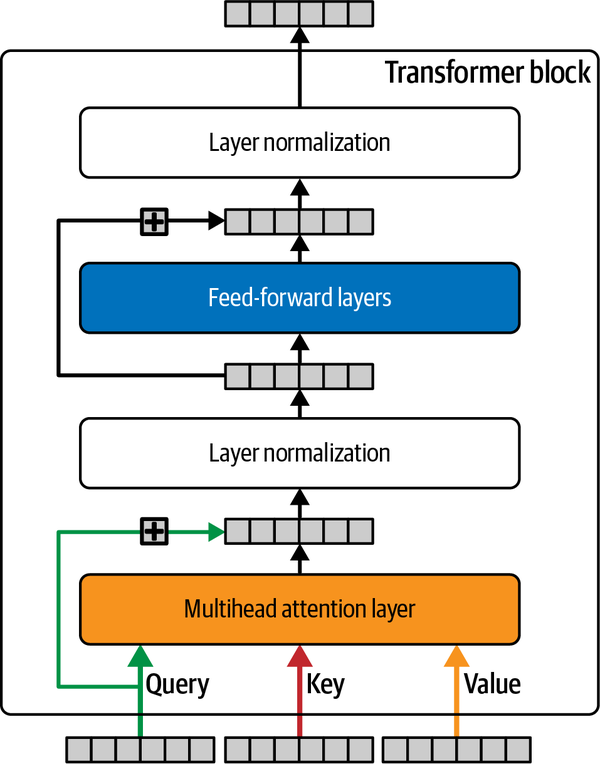

In [14]:
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, key_dim, embed_dim, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

# Positional Encoding in GPT Model

**Before we can proceed with training our GPT model, there’s a crucial step to address. You might have observed that the multihead attention layer doesn’t consider the sequence of the keys. The dot product between each key and the query is computed simultaneously, not sequentially as in a recurrent neural network. This parallel computation is advantageous due to efficiency gains, but it also presents a challenge. We need the attention layer to predict different outputs for different sentence contexts, such as:**

*The dog looked at the boy and …​ (barked?)*

*The boy looked at the dog and …​ (smiled?)*

**To overcome this issue, we employ a method known as positional encoding when generating the inputs for the initial Transformer block. Instead of merely encoding each token using a token embedding, we also encode the token’s position using a position embedding.**

**The token embedding is formed using a standard Embedding layer that transforms each token into a learned vector. Similarly, we can create the positional embedding using a standard Embedding layer that converts each integer position into a learned vector.**

**The joint token-position encoding is constructed by adding the token embedding to the positional embedding. This approach ensures that each word’s meaning and position in the sequence are encapsulated in a single vector.**

In [15]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = layers.Embedding(input_dim=max_len, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_len": self.max_len,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

In [16]:
inputs = layers.Input(shape=(None,), dtype=tf.int32)
x = TokenAndPositionEmbedding(MAX_LEN, VOCAB_SIZE, EMBEDDING_DIM)(inputs)
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM
)(x)
outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
gpt = models.Model(inputs=inputs, outputs=[outputs, attention_scores])
gpt.compile("adam", loss=[losses.SparseCategoricalCrossentropy(), None])

# The TextGenerator class is a callback that generates text at the end of each epoch during model training:


*   __init__(self, index_to_word, top_k=10): This method initializes the TextGenerator object. It creates a mapping from words to their corresponding indices (word_to_index) using the provided index_to_word dictionary.
*   sample_from(self, probs, temperature): This method takes in a probability distribution (probs) and a temperature parameter. It adjusts the probabilities using the temperature (higher values make the distribution more uniform, lower values make it more peaky) and then samples a token from this adjusted distribution.
* generate(self, start_prompt, max_tokens, temperature): This method generates a sequence of tokens. It starts with converting the start_prompt into a list of tokens. Then, in a loop that continues until the generated sequence is max_tokens long or a stop token (0) is produced, it does the following:
 * Feeds the current sequence of tokens into the model to get the probabilities of each possible next token.
 * Samples a token from these probabilities using the sample_from method.
Appends the sampled token to the sequence.
 * Adds the sampled token to the start_prompt string for the next iteration.
* on_epoch_end(self, epoch, logs=None): This method is automatically called at the end of each epoch during training. It calls the generate method to generate a text sequence starting with “recipe for”, with a maximum length of 100 tokens, and a temperature of 1.0.













In [17]:
# Create a TextGenerator checkpoint
class TextGenerator(callbacks.Callback):
    def __init__(self, index_to_word, top_k=10):
        self.index_to_word = index_to_word
        self.word_to_index = {
            word: index for index, word in enumerate(index_to_word)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def generate(self, start_prompt, max_tokens, temperature):
        start_tokens = [
            self.word_to_index.get(x, 1) for x in start_prompt.split()
        ]
        sample_token = None
        info = []
        while len(start_tokens) < max_tokens and sample_token != 0:
            x = np.array([start_tokens])
            y, att = self.model.predict(x, verbose=0)
            sample_token, probs = self.sample_from(y[0][-1], temperature)
            info.append(
                {
                    "prompt": start_prompt,
                    "word_probs": probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_tokens.append(sample_token)
            start_prompt = start_prompt + " " + self.index_to_word[sample_token]
        print(f"\ngenerated text:\n{start_prompt}\n")
        return info

    def on_epoch_end(self, epoch, logs=None):
        self.generate("product review:", max_tokens=100, temperature=1)

In [18]:
#Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
text_generator = TextGenerator(vocab)

In [19]:
gpt.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback, tensorboard_callback, text_generator],
)

Epoch 1/5
1560/1560 [==============================] - ETA: 0s - loss: 1.5844 - dense_2_loss: 1.5844
generated text:
product review: : self mon disappointed skinsupplement supplement | i been using this i have a sephora rep skeptical about 5 [UNK] so i purchased it and i love amethyst pure [UNK] almost a serum . so i find that are too much easier than [UNK] . it is a must come out well and my face like any to get through it . i’ve tried that aspect is . 

1560/1560 [==============================] - 247s 154ms/step - loss: 1.5844 - dense_2_loss: 1.5844
Epoch 2/5
1560/1560 [==============================] - ETA: 0s - loss: 1.3148 - dense_2_loss: 1.3148
generated text:
product review: [UNK] [UNK] este [UNK] [UNK] [UNK] [UNK] en [UNK] [UNK] [UNK] y el [UNK] [UNK] [UNK] [UNK] tan [UNK] : [UNK] para [UNK] for je [UNK] shape compare piel en [UNK] y con y [UNK] el [UNK] y y para piel [UNK] más [UNK] [UNK] para piel y con la mi piel [UNK] [UNK] [UNK] [UNK] [UNK] para en [UNK] [UNK] piel y for 

In [21]:
def print_probs(info, vocab, top_k=5):
    for i in info:
        highlighted_text = []
        for word, att_score in zip(
            i["prompt"].split(), np.mean(i["atts"], axis=0)
        ):
            highlighted_text.append(
                '<span style="background-color:rgba(135,206,250,'
                + str(att_score / max(np.mean(i["atts"], axis=0)))
                + ');">'
                + word
                + "</span>"
            )
        highlighted_text = " ".join(highlighted_text)
        display(HTML(highlighted_text))

        word_probs = i["word_probs"]
        p_sorted = np.sort(word_probs)[::-1][:top_k]
        i_sorted = np.argsort(word_probs)[::-1][:top_k]
        for p, i in zip(p_sorted, i_sorted):
            print(f"{vocab[i]}:   \t{np.round(100*p,2)}%")
        print("--------\n")

# Examples :

In [22]:
info = text_generator.generate(
    "review for hyaluronic acid booster", max_tokens=100, temperature=0.05
)


generated text:
review for hyaluronic acid booster | i love this product ! i have dry skin and this product is amazing . i have been using it for a few weeks now and i can see a difference in my skin . i have been using this product for a few weeks now and i can see a difference in my skin . 



In [23]:
info = text_generator.generate(
    "review for hyaluronic acid booster", max_tokens=100, temperature=0.5
)


generated text:
review for hyaluronic acid booster | i have been using this serum for a while . i was going to try it . it is amazing and i love it . it is very hydrating , and it doesn’t leave my skin oily or oily . i have sensitive skin and this was my first time trying it . i love it and will continue to buy when i run out . 



In [25]:
info = text_generator.generate(
    "review for hyaluronic acid booster", max_tokens=100, temperature=1
)


generated text:
review for hyaluronic acid booster | lancôme signature moisturizer . shani darden is a good moisturizer ! this product , but i’m 38 and my skin looks so bright after a long day ! leaves my skin hydrated and looks fantastic . holy grail product ! 



The temperature parameter in the generate method of the TextGenerator class controls the randomness of the text generation process. A lower temperature makes the output more deterministic, while a higher temperature makes it more diverse and random.

In the first and second example, with temperature=0.05 and 0.5, the generated text is more coherent and repetitive. The model tends to choose the most likely next word, leading to phrases like “this is the perfect size” and “this is the perfect amount of hydration” being repeated.

In the second example, with temperature=1, the generated text is more diverse and less predictable. The model is more likely to choose less probable words as the next word, leading to a more varied and creative output.

So, the temperature parameter allows you to control the trade-off between diversity and coherence in the generated text. A lower temperature leads to more predictable and coherent text, while a higher temperature leads to more diverse and creative text. However, too high a temperature might result in nonsensical text, and too low a temperature might result in overly repetitive text.

In [ ]:
print_probs(info, vocab)

### This is a basic guide on how to code a GPT model from scratch to generate reviews of beauty products. The code can be further improved and optimized based on the specific requirements of the task. For example, more sophisticated preprocessing and tokenization methods can be used, the model architecture can be modified, and different training strategies can be employed. The generated reviews can also be post-processed to ensure they meet certain criteria, such as length, coherence, and relevance to the product. The model can also be evaluated on a separate test set to assess its performance.

# Market Research with GPT Model
In this part we use our basic model to perform a basic market research on the popularity of a given product, but you may ask yourself what not just use the existing reviews ?
Well analyzing synthetic reviews generated by models like GPT has several advantages over analyzing only existing customer reviews:

* Volume and Diversity: Synthetic reviews can provide a large volume of data, which is especially useful when there are not enough real reviews available. This helps in understanding a wide range of potential customer opinions and experiences.
* Controlled Variables: When generating synthetic reviews, specific product features or customer profiles can be targeted, allowing for a more controlled study of particular aspects of consumer feedback, in our particular case this is not doable because we only used the product and its review but in the data we had far more context information we could have used to achieve this.
* Cost-Effective: Generating synthetic reviews is often less expensive than collecting a large number of real customer reviews, especially for new or hypothetical products.
* Risk Mitigation: For unreleased products, synthetic reviews can help predict customer reactions without the risk of negative publicity that could arise from real negative reviews.
* Ethical Considerations: Synthetic reviews eliminate the privacy concerns associated with analyzing real customer data, as they do not contain any personal information.
* Speed: Synthetic reviews can be generated quickly, enabling rapid analysis and decision-making.
* Testing Hypotheses: They allow companies to test out how changes in the product might affect customer satisfaction before actually making those changes.

In [26]:
product = 'Rose Quartz Facial Roller'.lower()

In [ ]:
synth_review = []
for _ in range(100):
  info = text_generator.generate(
    "review for "+product , max_tokens=100, temperature=0.5)
  synth_review.append(info[-1]['prompt'])

In [33]:
# lets take a look on couple of reviews
import pprint
samples = np.random.choice(synth_review, 10)
for sample in samples:
  pprint.pp(sample)

'review for rose quartz facial roller | i love this roller . i use it with the sonic facial roller and it makes my face feel so much better . i use it after i use it and i think it helps with my acne and it helps me a lot .'
'review for rose quartz facial roller | i have been using this for a couple weeks now and i love it ! ! ! ! i have sensitive skin and this makes my skin feel so nice and cool ! i have sensitive skin and i think it [UNK] my face is getting chapped after using this .'
'review for rose quartz facial roller | i love this roller ! i use it every morning and it makes my face feel so smooth and i use it in the morning before i use my makeup . it is so relaxing . it’s so relaxing and i use it after my moisturizer and it feels so nice .'
'review for rose quartz facial roller | i absolutely love it ! ! the roller is a lot more than the [UNK] .'
'review for rose quartz facial roller | i have been using this for a couple weeks now and i love it ! ! ! ! i have sensitive skin an

In [42]:
import random
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
def analyze_sentiment(reviews):
    sentiments = []
    for review in reviews:
        blob = TextBlob(review[len('review for rose quartz facial roller set |'):])
        sentiments.append(blob.sentiment.polarity)
    return sentiments

def aggregate_data(sentiments):
    sentiment_counts = Counter(sentiments)
    return sentiment_counts

def visualize_results(sentiments, sentiment_counts):
    sns.histplot(sentiments, kde=False)
    plt.xlabel('Sentiment polarity')
    plt.ylabel('Frequency')
    plt.title('Histogram of Sentiment polarities')
    plt.show()
    plt.bar(sentiment_counts.keys(), sentiment_counts.values(), width = 0.1)
    plt.xlabel('Sentiment polarity')
    plt.ylabel('Count')
    plt.show()

### TextBlob returns polarity and subjectivity of a sentence. Polarity lies between [-1,1], -1 defines a negative sentiment and 1 defines a positive sentiment. So as you can see below most values are > 0 and a some of them are  close to 1 which means most of the reception of this product is mostly positive

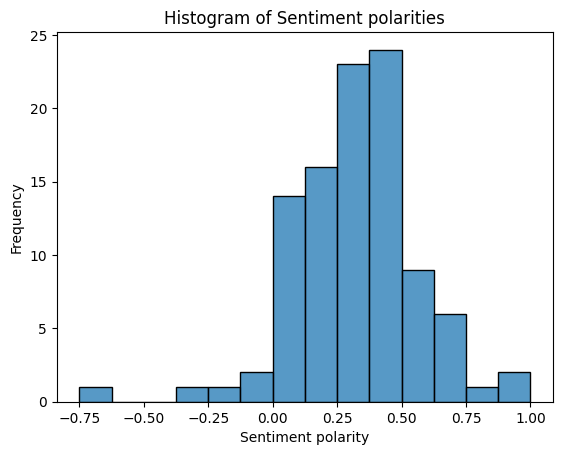

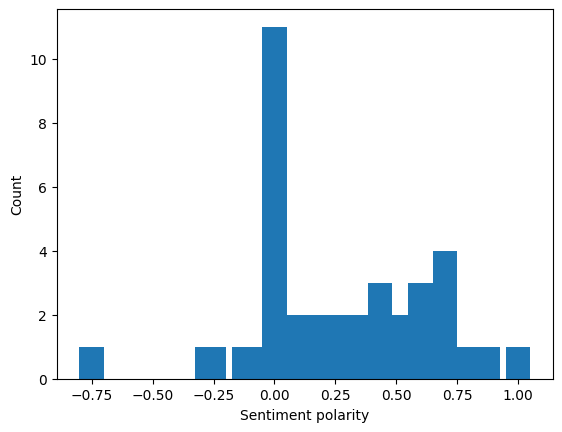

In [43]:
# Analyze sentiment
sentiments = analyze_sentiment(synth_review)

# Aggregate data
sentiment_counts = aggregate_data(sentiments)

# Visualize results
visualize_results(sentiments, sentiment_counts)

# Bibliography and references

[1] : https://aws.amazon.com/what-is/autoregressive-models/

[2] : Probabilistic Machine Learning: Advanced Topics ,  Kevin P Murphy 2023

[3] : Generative Deep Learning 2nd Edition, David Foster 2023

[4] : https://machinelearningmastery.com/how-to-implement-multi-head-attention-from-scratch-in-tensorflow-and-keras/